# Inclusion Stress Field Prediction

Импортируем библиотеки:

In [1]:
import os
import glob

import cv2

import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_style('darkgrid')

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn

import torchvision
from torchvision import transforms, models
from torchmetrics import MeanSquaredError
from torchmetrics import MeanAbsoluteError

import albumentations as A

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'
torch.manual_seed(42)
cudnn.deterministic = True
cudnn.benchmark = False
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Обозначим константы:

In [2]:
#Model Constants
IMAGE_SIZE = 256
BATCH_SIZE = 5
LAMBDA_L1 = 100
LEARNING_RATE = 1e-2
EPOCH = 300
MODEL_NAME = 'Colorizer'

Основные пути к папкам, откуда мы будем брать исходные данные для данного проекта:

In [3]:
path_folder = 'S:/abaqus_job_files/plot\\'
path_table = 'S:/abaqus_job_files/stresses_data/general_array.csv'
path_inclusions_count = 'S:/abaqus_job_files/stresses_data/inclusions.csv'
path_radius = 'S:/abaqus_job_files/stresses_data/radius_array.csv'
path_model_save = 'S:/abaqus_job_files/models/'

## Работа с табличными данными

In [4]:
def data_preparation(path=path_folder,
                     path_array=path_table,
                     path_incl=path_inclusions_count,
                     path_rad=path_radius):
    
    plots = ['mises', 'geom']
    
    #read data
    df = pd.read_csv(path_array, delimiter=' ', header=0).round(2)
    df['inclusions'] = pd.read_csv(path_incl, delimiter=' ', header=0).round(0).values
    df['radius'] = pd.read_csv(path_rad, delimiter=' ', header=0).values
    df['area'] = (np.pi * (df['radius']) ** 2) * df['inclusions']
    df.index += 1
    
    for i in plots:

        raw_images = sorted(glob.glob(path + '/*' + i + '*'), key=len)
        df['images_' + i] = raw_images
    
    #df = df.dropna(axis=1)
    df_train, df_valid = train_test_split(df,
                                          train_size=.8,
                                          random_state=42,
                                          shuffle=True)
    
    print(f'Train shape: {df_train.shape[0]}')
    print(f'Valid shape: {df_valid.shape[0]}')
        
    return df_train, df_valid

Разделим данные на тренировочную, валидационную и тестовую выборки.

In [5]:
df_train, df_valid = data_preparation()

Train shape: 800
Valid shape: 200


In [6]:
df_train.head()

,max_stress,min_stress,inclusions,radius,area,images_mises,images_geom
30,139.83,95.60,11.0,0.574,11.385873,S:/abaqus_job_files/plot\30_mises.png,S:/abaqus_job_files/plot\30_geom.png
536,164.12,87.17,24.0,0.742,41.511548,S:/abaqus_job_files/plot\536_mises.png,S:/abaqus_job_files/plot\536_geom.png
696,131.88,91.16,11.0,0.779,20.970920,S:/abaqus_job_files/plot\696_mises.png,S:/abaqus_job_files/plot\696_geom.png
558,158.98,91.71,20.0,0.610,23.379733,S:/abaqus_job_files/plot\558_mises.png,S:/abaqus_job_files/plot\558_geom.png
837,163.74,89.45,23.0,0.825,49.179669,S:/abaqus_job_files/plot\837_mises.png,S:/abaqus_job_files/plot\837_geom.png


## EDA

Оценим распределение представленных величин.

In [7]:
def kde_plot(data_list):
    
    columns = ['max_stress', 'min_stress']
    
    fig, ax = plt.subplots(1, 2, figsize=(13, 7))
    
    for data in data_list:
        for column, i in zip(columns, [0, 1]):
            
            sns.kdeplot(x=column,
                        data=data,
                        shade=True,
                        ax=ax[i])
            
            if i == 0:
                ax[i].set_ylabel('Density', fontsize=12)
            else:
                ax[i].set_ylabel('')
                
            ax[i].set_xlabel(f'{column}')
            ax[i].set_title(f'KDE of {column}')
            ax[i].legend(['Train', 'Valid'])
    
    fig.suptitle(f'Kernel density estimation of min and max stress variables', fontsize=18)
    fig.tight_layout()
    plt.show()

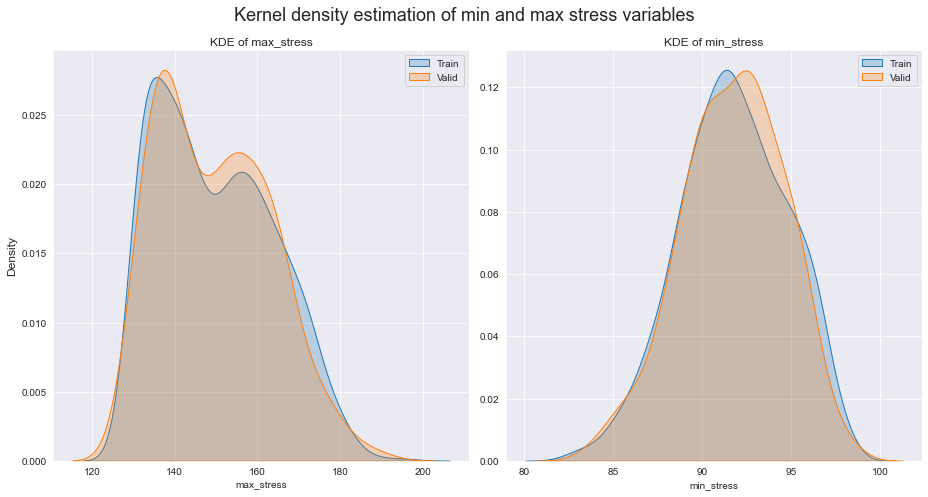

In [8]:
kde_plot([df_train, df_valid])

Распределения всех представленных величин крайне схожи по своей форме для различных наборов данных - тренировочного, валидационного и тестового датасетов.

## Загрузчик данных

Напишем загрузчик данных, который сможет выгружать датасеты по отдельным компонентам.

In [9]:
class StressDataset(torch.utils.data.Dataset):
    
    def __init__(self, df, transform=None):
        
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        
        #geometry preprocessing
        geometry = cv2.imread(self.df.iloc[index, -1], cv2.IMREAD_GRAYSCALE)
        #crop
        geometry = geometry[20:780, 331:1092]
        #resize
        geometry = cv2.resize(geometry, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_CUBIC)
        #normalize
        #geometry = (255 - geometry)
        geometry = cv2.threshold(geometry, 127, 255, cv2.THRESH_BINARY)[1]
        geometry = geometry / 255
        #add additional dimension
        geometry = np.array([geometry]).astype('float32')
          
        result = cv2.imread(self.df.iloc[index, -2], cv2.IMREAD_GRAYSCALE)
        #crop
        result = result[118:637, 523:1043]
        #resize image
        result = cv2.resize(result, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_CUBIC)
        #normolize between 0 and 1
        result = result / 255
        
        #normalize between min and max stresses
        result = cv2.normalize(
            result, None, alpha=self.df.iloc[index, 1], beta=self.df.iloc[index, 0], norm_type=cv2.NORM_MINMAX
        )
        result = np.array([result]).astype('float32')
        
        #augmentation
        if self.transform is not None:
            aug = self.transform(image=result, mask=geometry)
            result = aug['image']
            geometry = aug['mask']
        
        #convert to torch.Tensor
        geometry = torch.from_numpy(geometry.copy()).type(torch.float32)
        result = torch.from_numpy(result.copy()).type(torch.float32)
        
        return (geometry, result)

In [10]:
train_transform = A.Compose([
    A.HorizontalFlip(p=1),
    A.VerticalFlip(p=1)
])

Начнем работу с компоненты тензора напряжений - $\bf{\sigma_{11}}$.

In [11]:
train_dataset = StressDataset(df_train, transform=train_transform)
valid_dataset = StressDataset(df_valid)

In [12]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [13]:
def image_show_tensor(dataloader, number_of_images=3, initial_index=0, values_name=None):
    
    masks, images = next(iter(dataloader))

    fig = plt.figure(figsize=(20, 20))
    
    for idx, tensor in enumerate([masks, images]):
        
        tensor = tensor.numpy().transpose(0,2,3,1)
        
        fig = plt.figure(figsize=(20, 20))
        
        for i in range(number_of_images):

            fig.add_subplot(1, number_of_images+1, i+1)
            
            min = (tensor[i+initial_index]).min()
            max = (tensor[i+initial_index]).max()
            
            if idx == 0:
                plt.imshow(tensor[i+initial_index], cmap='PuBu')
                plt.title(f'Geometry Inclusion={min:.0f}; Matrix={max:.0f}')
            else:
                plt.imshow(tensor[i+initial_index], cmap='icefire')
                plt.title(f'von Mises Stress Min={min:.2f}; Max={max:.2f}')

            plt.clim(min, max)
            plt.colorbar(shrink=0.2015)
            
            plt.xticks([])
            plt.yticks([])
            plt.tight_layout()
            
    plt.show()

<Figure size 1440x1440 with 0 Axes>

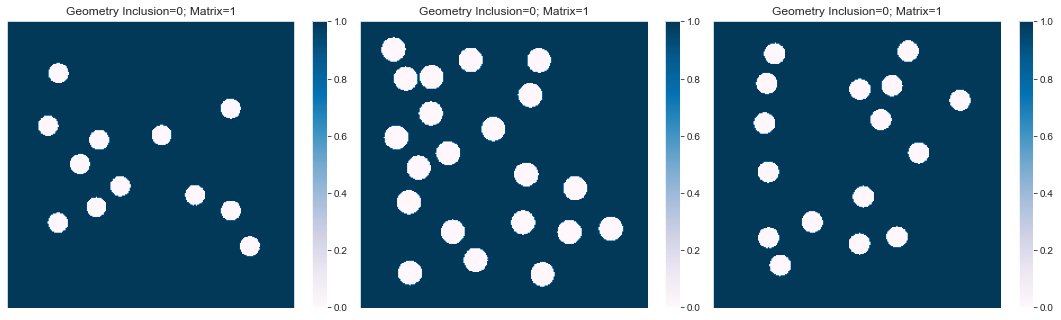

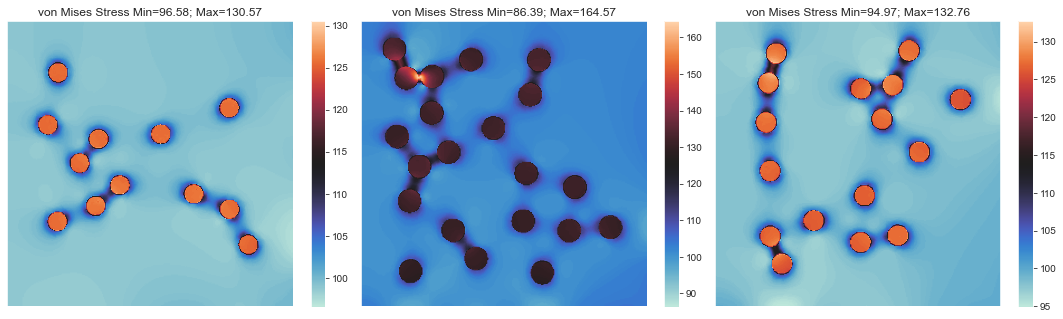

In [14]:
image_show_tensor(train_dataloader)

## Модель 

In [15]:
class ColorizationNet(nn.Module):
    def __init__(self, input_size=IMAGE_SIZE):
        super(ColorizationNet, self).__init__()
        MIDLEVEL_FEATURE_SIZE = 128

        ## First half: ResNet
        resnet = models.resnet18(num_classes=365) 
        # Change first conv layer to accept single-channel (grayscale) input
        resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1)) 
        # Extract midlevel features from ResNet-gray
        self.midlevel_resnet = nn.Sequential(*list(resnet.children())[0:6])

        ## Second half: Upsampling
        self.upsample = nn.Sequential(     
          nn.Conv2d(MIDLEVEL_FEATURE_SIZE, 128, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(128),
          nn.ReLU(),
          nn.Upsample(scale_factor=2),
          nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.Upsample(scale_factor=2),
          nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(32),
          nn.ReLU(),
          nn.Conv2d(32, 1, kernel_size=1, stride=1, padding=0),
          nn.Upsample(scale_factor=2)
        )

    def forward(self, input):

        # Pass input through ResNet-gray to extract features
        midlevel_features = self.midlevel_resnet(input)

        # Upsample to get colors
        output = self.upsample(midlevel_features)
        return output

In [16]:
model = ColorizationNet().to(device, dtype=torch.float)

Используем предобученную модель.

Обозначим дополнительную метрику оценки качества работы модели:

In [17]:
mean_squared_error = nn.MSELoss()

Определим **loss**-функцию и **optimizer**.

In [18]:
loss = nn.L1Loss()

In [19]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=0.0)

## Обучение

In [20]:
mae_train_loss_history, mae_valid_loss_history = [], []
mse_train_loss_history, mse_valid_loss_history = [], []

for epoch in range(EPOCH):
    
    mae_train_batch_loss_history, mae_valid_batch_loss_history = [], []
    mse_train_batch_loss_history, mse_valid_batch_loss_history = [], []
    
    #train
    model.train()
    for geometry, result in train_dataloader:
        
        optimizer.zero_grad()
        
        geometry = geometry.to(device, dtype=torch.float)
        result = result.to(device, dtype=torch.float)
        
        pred = model(geometry)
        
        mae_train = loss(pred, result) 
        mse_train = mean_squared_error(pred, result)
        
        mae_train_batch_loss_history.append(mae_train.item())
        mse_train_batch_loss_history.append(mse_train.item())
        
        mae_train.backward()
        optimizer.step()
        
        del geometry, result
        torch.cuda.empty_cache()
        
    #valid
    model.eval()
    for geometry, result in valid_dataloader:
        
        geometry = geometry.to(device, dtype=torch.float)
        result = result.to(device, dtype=torch.float)
        
        pred = model(geometry)
        
        mae_valid = loss(pred, result) 
        mse_valid = mean_squared_error(pred, result)
        
        mae_valid_batch_loss_history.append(mae_valid.item())
        mse_valid_batch_loss_history.append(mse_valid.item())
        
        del geometry, result
        torch.cuda.empty_cache()
    
    mae_train_loss = np.mean(mae_train_batch_loss_history)
    mae_train_loss_history.append(mae_train_loss)
    mse_train_loss = np.mean(mse_train_batch_loss_history)
    mse_train_loss_history.append(mse_train_loss)
    
    mae_valid_loss = np.mean(mae_valid_batch_loss_history)
    mae_valid_loss_history.append(mae_valid_loss)
    mse_valid_loss = np.mean(mse_valid_batch_loss_history)
    mse_valid_loss_history.append(mse_valid_loss)

    print(
        f'{epoch} | MAE:{mae_train_loss:.4f} | MAE valid:{mae_valid_loss:.4f} | MSE:{mse_train_loss:.4f} | MSE valid:{mse_valid_loss:.4f}'
    )

0 | MAE:51.2176 | MAE valid:4.3855 | MSE:4265.6344 | MSE valid:36.4316
1 | MAE:2.8584 | MAE valid:2.9880 | MSE:20.3687 | MSE valid:17.3189
2 | MAE:2.5203 | MAE valid:2.3977 | MSE:16.5756 | MSE valid:13.1006
3 | MAE:2.3283 | MAE valid:2.0702 | MSE:14.6649 | MSE valid:10.7604
4 | MAE:2.2122 | MAE valid:2.2663 | MSE:12.9676 | MSE valid:10.9490
5 | MAE:2.2302 | MAE valid:2.2479 | MSE:13.3874 | MSE valid:12.7213
6 | MAE:2.1423 | MAE valid:2.5096 | MSE:12.1610 | MSE valid:18.1129
7 | MAE:2.1371 | MAE valid:2.4239 | MSE:11.7592 | MSE valid:12.4806
8 | MAE:2.0413 | MAE valid:2.0267 | MSE:10.6861 | MSE valid:9.5544
9 | MAE:1.9997 | MAE valid:2.3823 | MSE:10.1264 | MSE valid:12.8281
10 | MAE:2.0776 | MAE valid:1.8693 | MSE:10.6494 | MSE valid:8.3048
11 | MAE:1.9704 | MAE valid:1.9514 | MSE:9.7202 | MSE valid:9.1347
12 | MAE:1.9559 | MAE valid:1.9859 | MSE:9.4073 | MSE valid:9.3000
13 | MAE:1.9440 | MAE valid:1.9847 | MSE:9.2227 | MSE valid:8.3684
14 | MAE:1.9429 | MAE valid:2.2775 | MSE:9.5021 |

122 | MAE:1.3212 | MAE valid:1.9789 | MSE:5.1822 | MSE valid:8.3613
123 | MAE:1.3519 | MAE valid:1.9304 | MSE:5.2399 | MSE valid:7.6253
124 | MAE:1.3585 | MAE valid:1.9461 | MSE:5.2397 | MSE valid:8.0854
125 | MAE:1.3119 | MAE valid:1.8561 | MSE:5.0684 | MSE valid:7.6359
126 | MAE:1.3427 | MAE valid:2.1516 | MSE:5.1399 | MSE valid:9.4048
127 | MAE:1.3780 | MAE valid:1.8766 | MSE:5.3913 | MSE valid:7.9626
128 | MAE:1.2719 | MAE valid:1.9056 | MSE:4.9576 | MSE valid:8.0706
129 | MAE:1.2851 | MAE valid:1.9149 | MSE:5.0064 | MSE valid:8.2618
130 | MAE:1.2915 | MAE valid:1.9154 | MSE:4.9810 | MSE valid:7.6107
131 | MAE:1.2581 | MAE valid:1.8647 | MSE:4.9073 | MSE valid:8.2188
132 | MAE:1.2742 | MAE valid:1.8455 | MSE:4.8886 | MSE valid:7.3831
133 | MAE:1.2451 | MAE valid:1.9719 | MSE:4.8090 | MSE valid:8.0778
134 | MAE:1.2243 | MAE valid:1.8706 | MSE:4.7866 | MSE valid:7.5923
135 | MAE:1.2563 | MAE valid:1.8710 | MSE:4.8788 | MSE valid:7.8626
136 | MAE:1.2422 | MAE valid:1.9467 | MSE:4.9020

243 | MAE:0.8301 | MAE valid:1.8681 | MSE:3.4941 | MSE valid:7.7061
244 | MAE:0.8664 | MAE valid:1.8338 | MSE:3.5735 | MSE valid:7.2980
245 | MAE:0.8468 | MAE valid:1.8810 | MSE:3.5122 | MSE valid:7.5649
246 | MAE:0.8367 | MAE valid:1.8157 | MSE:3.4901 | MSE valid:7.3626
247 | MAE:0.8304 | MAE valid:1.7996 | MSE:3.4771 | MSE valid:7.1935
248 | MAE:0.8198 | MAE valid:1.9667 | MSE:3.4546 | MSE valid:8.5115
249 | MAE:0.8486 | MAE valid:1.8437 | MSE:3.5179 | MSE valid:7.4666
250 | MAE:0.9009 | MAE valid:1.8428 | MSE:3.6248 | MSE valid:7.4108
251 | MAE:0.8869 | MAE valid:1.8740 | MSE:3.5834 | MSE valid:7.9064
252 | MAE:0.8151 | MAE valid:1.8044 | MSE:3.4332 | MSE valid:7.1855
253 | MAE:0.8112 | MAE valid:1.8742 | MSE:3.4121 | MSE valid:7.7549
254 | MAE:0.8111 | MAE valid:1.8522 | MSE:3.4347 | MSE valid:7.6139
255 | MAE:0.8008 | MAE valid:1.8248 | MSE:3.4310 | MSE valid:7.4313
256 | MAE:0.8146 | MAE valid:1.7930 | MSE:3.4355 | MSE valid:7.2075
257 | MAE:0.7796 | MAE valid:1.8406 | MSE:3.3626

Сохраним полученную модель генератора.

In [22]:
torch.save(model, path_model_save + 'vonMises' + MODEL_NAME)

## Результаты 

Отдельно сохраним результаты обучения модели.

In [23]:
dict_data = {'MAE Train' : mae_train_loss_history,
             'MAE Valid' : mae_valid_loss_history,
             'MSE Train' : mse_train_loss_history,
             'MSE Valid' : mse_valid_loss_history}

In [24]:
df_results = pd.DataFrame.from_dict(dict_data)
df_results.to_csv('S:/abaqus_job_files/results_data/loss_results_vonMises_' + MODEL_NAME + '.csv', sep=' ')

In [25]:
def loss_plot(data):
    
    mae_loss_names = data.columns[:2]
    mse_loss_names = data.columns[2:]
    legend_names = ['Train', 'Valid']
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    
    for i, j, k in zip(mae_loss_names, mse_loss_names, legend_names):
        
        ax[0].plot(data[i].values, label=k)
        ax[1].plot(data[j].values, label=k)
        
    for i, j in enumerate(['MAE', 'MSE']):

        ax[i].set_title(f'{j} Loss Plot', fontsize=14)
        ax[i].set_xlabel('Epoch', fontsize=12)
        ax[i].set_ylabel(f'{j} Loss Function Value', fontsize=12)
        ax[i].legend()
        
    fig.suptitle('Loss functions plot for von Mises', fontsize=18)
    plt.show()

Визуализируем значения функции потерь для каждого из датасетов.

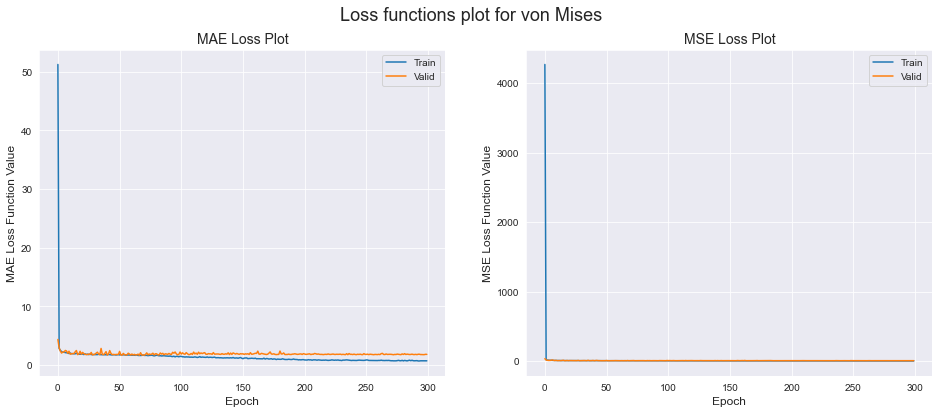

In [26]:
loss_plot(df_results)

Визуально оценим результаты работы алгоритма.

In [28]:
def singular_result(dataloader, model=model, initial_index=0, cmap='icefire', component='von Mises Stress'):
    
    model.eval()
    model = model.cpu()
    geometry, result = next(iter(dataloader))

    prediction = model(geometry.float())
    error = abs(result - prediction)

    tensors = [geometry, result, prediction, error]
    titles = ['Geometry', f'True {component} field', f'Predicted {component} field', '$L_{1}$ error']
    
    fig, ax = plt.subplots(2, 2, figsize=(12, 12))
    
    for tensor, title, i, j in zip(tensors, titles, [0, 0, 1, 1], [0, 1, 0, 1]): 
        
        tensor = tensor.cpu().detach().numpy().transpose(0,2,3,1)
        
        if i == 0 and j == 0:
            img = ax[i, j].imshow(tensor[initial_index], cmap='PuBu')
        elif i != j:
            img = ax[i, j].imshow(tensor[initial_index], cmap=cmap)
        else:
            img = ax[i, j].imshow(tensor[initial_index], cmap='coolwarm')
            
        ax[i, j].set_title(title, fontsize=14)
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        
        min = (tensor[initial_index]).min()
        max = (tensor[initial_index]).max()
        
        if i == 1 and j == 1:
            img.set_clim(0, max)
        else:
            img.set_clim(min, max)
            
        plt.colorbar(img, shrink=0.815, ax=ax[i, j])
            
    fig.suptitle(f'Visualization for the one sample of {component}', fontsize=18)
    fig.tight_layout()
    plt.show()

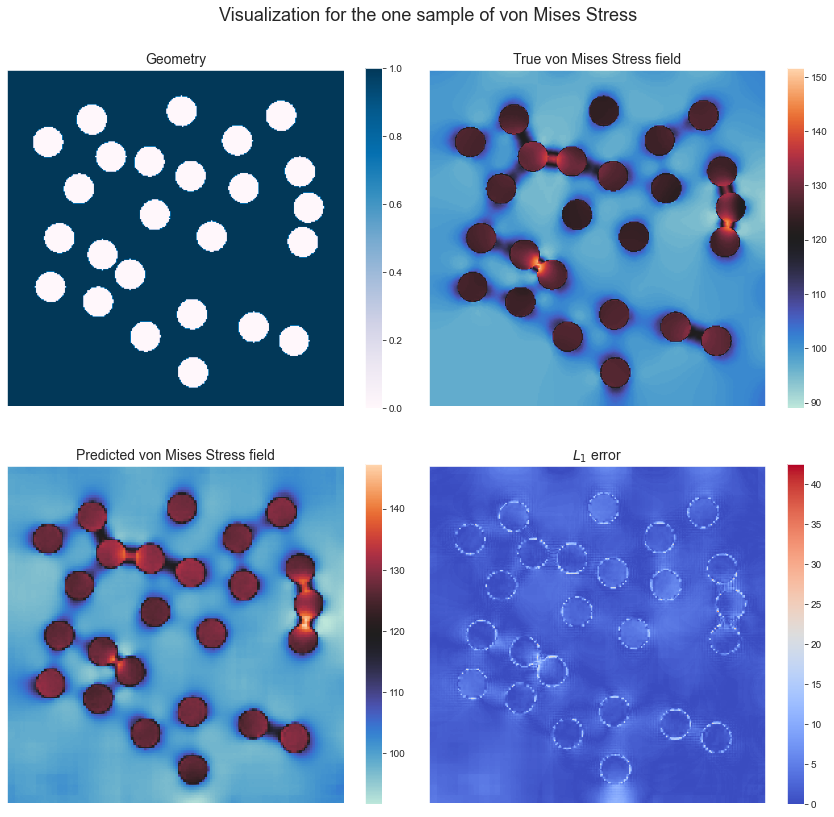

In [30]:
singular_result(valid_dataloader)